In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import torch

# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from models.unet.unet import UNet
from src.models.data_management.cnn_formes import CNNFormes
from src.data_processing.dataset_loader import CoastData
from src.models.data_management.data_loader import DataLoaderManager

import cv2

In [ ]:
# Load the data to split it and save it to a dict
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/patchify_4_classes/"))

In [ ]:
unet = UNet(num_classes=4, experiment_name="test_experiments", use_mlflow=False)

In [ ]:
# Load the data to the model
data = unet.load_data(path, CNNFormes)

Not classified percentage: 42.260%

Land percentage: 31.173%

Sea percentage: 26.415%

Shoreline percentage: 0.153%

---

not_classified = 42,260 / 42,260 =  1

land = 42,260 / 31,173 = 1,36

sea = 142,260 / 26,415 = 1,60

shoreline = 42,260 / 0,153 = 276,14


In [ ]:
weight = [1, 1.36, 1.60, 276.14]

artifact_path = os.path.abspath(os.path.join(path, "../../artifacts/"))

# Train the model
# unet.train(epochs=50, loss_function_name="BCEWithLogitsLoss", weight=weight, artifact_path=artifact_path)

# Predictions

(array([0, 1, 2, 3], dtype=uint8), array([46160, 14763,  4423,   190]))
(array([0, 1, 2, 3]), array([46134, 14873,  4349,   180]))


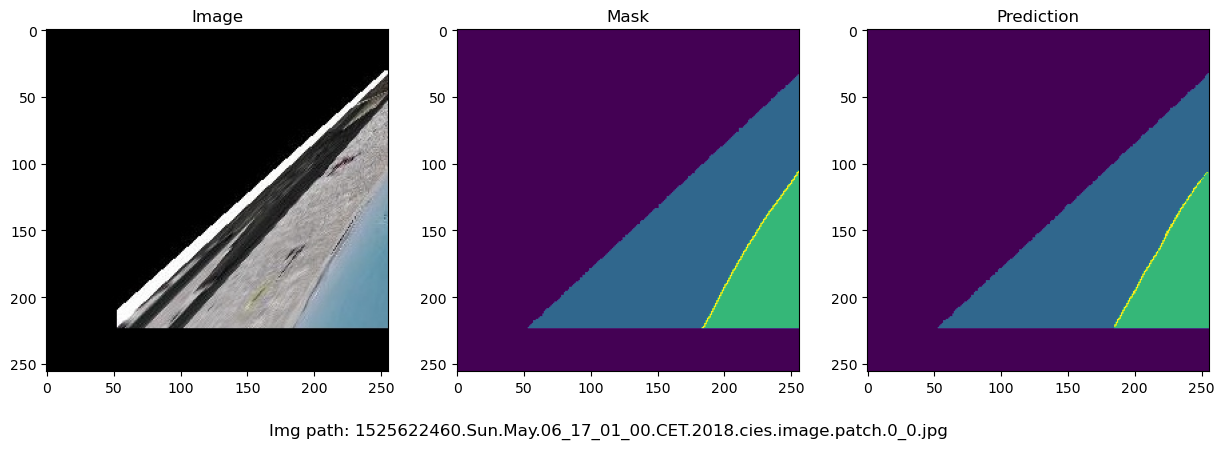

In [6]:
# Predict one patch
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/patchify_4_classes/"))

data = DataLoaderManager.load_data(data_path)
index = 0 # 72
img_path = data["test"]['images'][index]
mask_path = data["test"]['masks'][index]

unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# pred = unet.predict(img)
pred = unet.predict(img_path)

print(np.unique(mask, return_counts=True))
print(np.unique(pred, return_counts=True))


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f"Img path: {img_path.split('/')[-1]}", y=0.05)

ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].imshow(mask)
ax[1].set_title("Mask")

ax[2].imshow(pred.squeeze())
ax[2].set_title("Prediction")

plt.show()

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
(array([0, 1, 2, 3], dtype=uint8), array([194744, 155727, 213667,   1022]))
(array([0, 1, 2, 3]), array([193871, 153969, 216995,    325]))


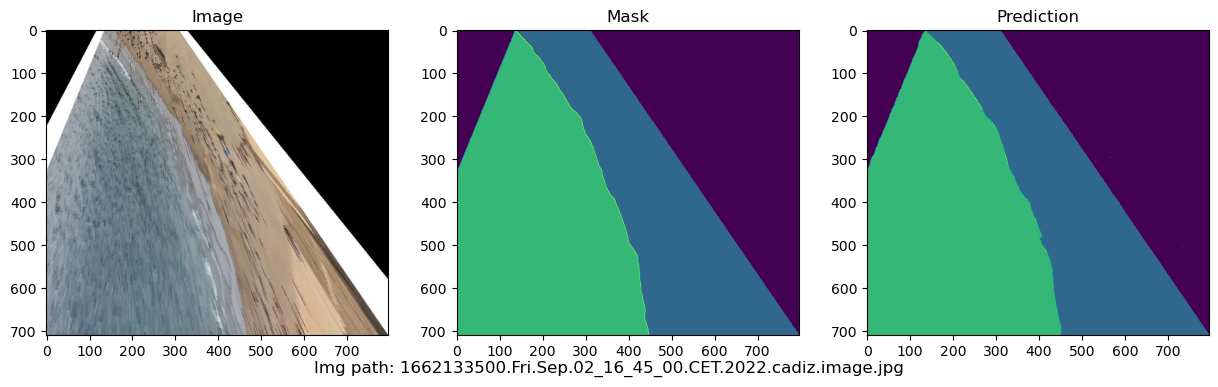

In [7]:
# Predict the full image
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))
data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)
index = 100 # 25 # 72
img_path = data["test"]['images'][index]
mask_path = data["test"]['masks'][index]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

pred = unet.predict_patch(img_path, combination="max")

print(np.unique(mask, return_counts=True))
print(np.unique(pred, return_counts=True))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle(f"Img path: {img_path.split('/')[-1]}", y=0.05)

ax[0].imshow(img)
ax[0].set_title("Image")

ax[1].imshow(mask)
ax[1].set_title("Mask")

ax[2].imshow(pred.squeeze())
ax[2].set_title("Prediction")

plt.show()

# Metrics

In [ ]:
from src.models.metrics import Metrics

artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))

num_classes = 4
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, loss=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, loss=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, loss=False)
}

# Load the data to split it and save it to a dict
unet = UNet(num_classes=num_classes, experiment_name="test_experiments", use_mlflow=False)
unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = unet.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update(mask, pred)
        break

    metrics[split].compute(epoch=0)
    print(metrics[split].get_last_epoch_info())

## Metrics with margin

In [ ]:
from src.models.metrics import Metrics

artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../artifacts/"))

num_classes = 4
margin = 10
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=True, margin = margin),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=True, margin = margin),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=True, margin = margin)
}

# Load the data to split it and save it to a dict
unet = UNet(num_classes=num_classes, experiment_name="test_experiments", use_mlflow=False)
unet.load_model(os.path.abspath(os.path.join(artifact_path, "2025-02-19-15-28-50/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/processed_4_classes/"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

for split in data:
    print(f"Split: {split}")
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = unet.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57
Split: train


/opt/miniconda3/envs/visio/lib/python3.9/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorAdvancedIndexing.cpp:234.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


train metrics: 
	train_accuracy: tensor([0.9310, 0.9842, 0.9684, 0.6570])
	train_f1_score: tensor([0.9643, 0.9686, 0.9703, 0.6991])
	train_precision: tensor([1.0000, 0.9536, 0.9722, 0.7469])
	train_recall: tensor([0.9310, 0.9842, 0.9684, 0.6570])
	train_confusion_matrix: tensor([[2.7000e+01, 0.0000e+00, 2.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.6140e+03, 2.0000e+00, 5.6000e+01],
        [0.0000e+00, 0.0000e+00, 3.9590e+03, 1.2900e+02],
        [0.0000e+00, 1.7600e+02, 1.0900e+02, 5.4600e+02]])

Split: validation
val metrics: 
	val_accuracy: tensor([1.0000, 0.6088, 0.7810, 0.0254])
	val_f1_score: tensor([1.0000, 0.6370, 0.7024, 0.0409])
	val_precision: tensor([1.0000, 0.6679, 0.6382, 0.1036])
	val_recall: tensor([1.0000, 0.6088, 0.7810, 0.0254])
	val_confusion_matrix: tensor([[  19.,    0.,    0.,    0.],
        [   0., 2252., 1392.,   55.],
        [   0.,  782., 3210.,  118.],
        [   0.,  338.,  428.,   20.]])

Split: test
test metrics: 
	test_accuracy: tensor([   nan, 0.6